### RNN 

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import tensorflow as tf
from tensorflow import keras
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [287]:
# import the data
netflix = pd.read_csv('netflix_model_ready.csv',
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col="date"
                        )
                      


In [179]:
# Time series train/test split
tss= TimeSeriesSplit(n_splits=2)

# Keep all features, but remove the five target variables
X = netflix.iloc[:, :-5]

# Create series for target 
y = netflix.iloc[:, -3]

# Split tranining and test data by date
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [7]:
# Standardize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# PCA feature reduction. 20 components is enough to explain ~85% of the variance (refer to Feture_selection notebook)
sklearn_pca = PCA(n_components=20)
X_train_pca = sklearn_pca.fit_transform(X_train)
X_test_pca = sklearn_pca.transform(X_test)

In [94]:
X_train_3D = np.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_3D = np.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))


In [95]:
X_test_3D.shape

(240, 1, 20)

In [96]:
# Construct Long-Short Term Memory (LSTM) model
lstm = Sequential()
lstm.add(LSTM(units = 100, return_sequences = True, input_shape = (1, X_train_pca.shape[1]))) 
lstm.add(Dense(units = 1, activation="sigmoid"))

In [97]:
# Compile
lstm.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Fit 
history = lstm.fit(X_train_3D, 
                y_train, 
                epochs = 10, 
                validation_data=(X_test_3D, y_test),
                batch_size = 10)

Epoch 1/10
49/49 [==============================] - 2s 11ms/step - loss: 0.6950 - accuracy: 0.4678 - val_loss: 0.6919 - val_accuracy: 0.5208
Epoch 2/10
49/49 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5717 - val_loss: 0.6923 - val_accuracy: 0.5208
Epoch 3/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5967 - val_loss: 0.6935 - val_accuracy: 0.5083
Epoch 4/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5967 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 5/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5738 - val_loss: 0.6947 - val_accuracy: 0.5125
Epoch 6/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5925 - val_loss: 0.6973 - val_accuracy: 0.4917
Epoch 7/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5904 - val_loss: 0.6979 - val_accuracy: 0.5042
Epoch 8/10
49/49 [=

In [34]:
test_preds = lstm.predict(X_test_3D)
lstm.evaluate(X_test_3D, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5208


[0.6924440264701843, 0.5208333134651184]

<AxesSubplot:>

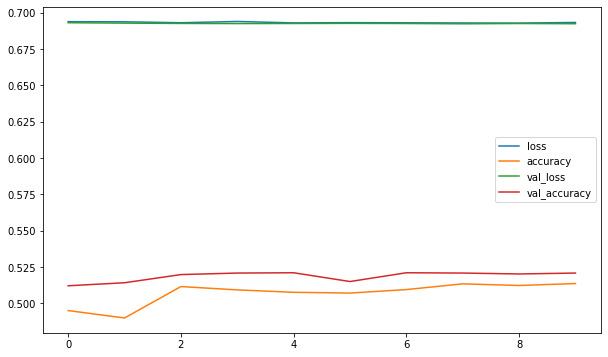

In [36]:
pd.DataFrame(history.history).plot(figsize=(10,6))

### Approach 2

In [288]:
netflix = netflix.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
target_3 = netflix["target_3"]

#splitting into training sets 
column_indices = {name: i for i, name in enumerate(netflix.columns)}

n = len(netflix)
X_train = netflix[0:int(n*0.7)]
X_val = netflix[int(n*0.7):int(n*0.9)]
X_test = netflix[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [289]:
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = netflix.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = netflix.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = netflix.columns)

In [290]:
def df_to_X_y2(df, target, window_size=5):
  df_as_np = df.to_numpy() # converts to matrix of numpy arrays
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df_as_np[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

In [291]:
sklearn_pca = PCA(n_components=20)
X_train_1 = pd.DataFrame(sklearn_pca.fit_transform(X_train))
X_val_1 = pd.DataFrame(sklearn_pca.fit_transform(X_val))
X_test_1 = pd.DataFrame(sklearn_pca.fit_transform(X_test))

# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_1,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_1, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_1,y_test) 

X_train1, train_5w = np.array(X_train), np.array(train_5w).reshape(-1,1)
X_val1, val_5w = np.array(X_val), np.array(val_5w).reshape(-1,1)
X_test1, test_5w = np.array(X_test), np.array(test_5w).reshape(-1,1)


print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(499, 5, 20) (499, 1)
(139, 5, 20) (139, 1)
(68, 5, 20) (68, 1)


In [294]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [295]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 5, 8)              928       
                                                                 
 batch_normalization_18 (Bat  (None, 5, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_51 (LSTM)              (None, 5, 8)              544       
                                                                 
 batch_normalization_19 (Bat  (None, 5, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_52 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_20 (Bat  (None, 8)              

In [296]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=50,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/50
10/10 [==============================] - 7s 96ms/step - loss: 3.0795 - accuracy: 0.5090 - val_loss: 2.7982 - val_accuracy: 0.4964
Epoch 2/50
10/10 [==============================] - 0s 20ms/step - loss: 2.8663 - accuracy: 0.5311 - val_loss: 2.6723 - val_accuracy: 0.5612
Epoch 3/50
10/10 [==============================] - 0s 22ms/step - loss: 2.7051 - accuracy: 0.5251 - val_loss: 2.5517 - val_accuracy: 0.5755
Epoch 4/50
10/10 [==============================] - 0s 23ms/step - loss: 2.5529 - accuracy: 0.5511 - val_loss: 2.4371 - val_accuracy: 0.5827
Epoch 5/50
10/10 [==============================] - 0s 23ms/step - loss: 2.4148 - accuracy: 0.5571 - val_loss: 2.3281 - val_accuracy: 0.5827
Epoch 6/50
10/10 [==============================] - 0s 22ms/step - loss: 2.3021 - accuracy: 0.5371 - val_loss: 2.2255 - val_accuracy: 0.5827
Epoch 7/50
10/10 [==============================] - 0s 22ms/step - loss: 2.1997 - accuracy: 0.5571 - val_loss: 2.1296 - val_accuracy: 0.5827
Epoch 8/50
10

In [297]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 63.5271%
test accuracy = 44.1176%
test error = 38 out of 68 examples


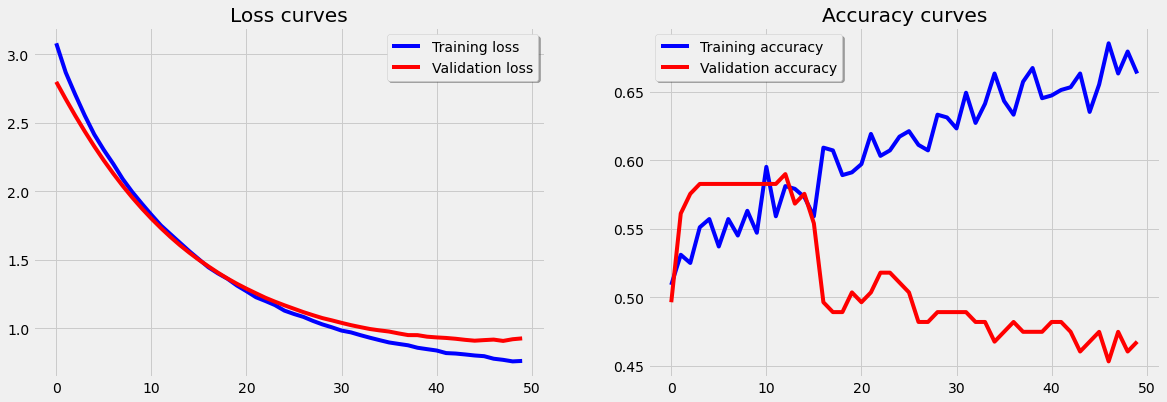

In [298]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()